## Notebook3: Content-Based Recommendation Systems

In [1]:
# Importing the necessary packages
import pandas as pd
import os 
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import jaccard, correlation
from scipy.stats import pearsonr
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances
from wordcloud import WordCloud


In [2]:
# Base directory for data files
base_path = '/l/users/chaimaa.abi/BigData2/BigData/Dataset/ml-25m/ml-25m'
# Load movie titles and genres
movie_genres = pd.read_csv(os.path.join(base_path, 'movies.csv'))
# Load genome scores associated with movies (tags)
genome_scores = pd.read_csv(os.path.join(base_path, 'genome-scores.csv'))
# Load descriptions for the genome tags
genome_tags_descriptions = pd.read_csv(os.path.join(base_path, 'genome-tags.csv'))

## Movie Title Cleaning Steps

In the `process_movie_titles` function, we streamline and standardize the movie titles in our dataset through several cleaning operations:

### Key Cleaning Operations:

1. **Year Extraction and Removal**: 
   - The function extracts the year from the end of the movie title and removes it, which helps in decluttering the title and storing the year in a dedicated column.

2. **Normalization**:
   - Movie titles are converted to lowercase and any leading or trailing whitespace is removed to ensure uniformity across all titles.

3. **Special Character Cleanup**:
   - Non-alphanumeric characters are removed from titles, except for necessary commas in prefixes. This step avoids potential mismatches and duplicates in the dataset due to formatting differences.

4. **Prefix Correction**:
   - Titles that end with ', The', ', An', or ', A' are corrected by moving these prefixes to the start of the title. This adjustment ensures that titles are displayed in a more natural and readable format.

In [3]:
def process_movie_titles(dataframe):
    def movie_title_clean(title):
        # Normalize case and strip whitespace
        title = title.strip().lower()
        
        # Regex to extract year and remove it from the title
        pattern = re.compile(r'\s*\((\d{4})\)\s*$')
        year_match = pattern.search(title)
        year = 9999
        if year_match:
            year = int(year_match.group(1))
            title = title[:year_match.start()].strip()  # Remove the year part from the title
        
        # Removing all special characters after processing ', The/A/An'
        title = re.sub(r'[^\w\s,]', '', title)

        # Correct common title prefixes moved to suffixes
        if title.endswith(', the'):
            title = 'The ' + title[:-5].strip()
        elif title.endswith(', an'):
            title = 'An ' + title[:-4].strip()
        elif title.endswith(', a'):
            title = 'A ' + title[:-3].strip()

        return title, year

    # Strip whitespace from titles and apply the movie_title_clean function
    title_year_tuple = dataframe['title'].str.strip().apply(movie_title_clean)
    
    # Split the tuples into separate columns for title and release year
    dataframe['Title'] = title_year_tuple.apply(lambda x: x[0])
    dataframe['Release Year'] = title_year_tuple.apply(lambda x: x[1])

process_movie_titles(movie_genres)
movie_genres = movie_genres.drop('title', axis=1)

In [4]:
movie_genres.head()

,movieId,genres,Title,Release Year
0,1,Adventure|Animation|Children|Comedy|Fantasy,toy story,1995
1,2,Adventure|Children|Fantasy,jumanji,1995
2,3,Comedy|Romance,grumpier old men,1995
3,4,Comedy|Drama|Romance,waiting to exhale,1995
4,5,Comedy,father of the bride part ii,1995


**Movie Genre Data Processing**
- Filters out movies without listed genres.
- Expands and encodes genres into binary indicators.
- Aggregates these indicators by movie ID.
- Converts aggregated data into lists for each movie.

In [5]:
# Removing rows with no genres listed and splitting genres into separate rows
filtered_genres = (
    movie_genres[movie_genres['genres'] != '(no genres listed)']
    .set_index('movieId')  # Set movieId as index
    .genres.str.split('|', expand=True)  # Split genres and expand into separate columns
    .stack()  # Stack to convert from wide to long format
    .reset_index(level=1, drop=True)  # Drop the unnecessary level created by stack
)

# Converting genres to binary indicators (one-hot encoding) and summing them up by movieId
binary_indicators = (
    pd.get_dummies(filtered_genres, prefix='g')  # Create one-hot encoded dataframe
    .groupby(level=0)  # Group by movieId
    .sum()  # Sum binary indicators
    .reset_index()  # Reset index to turn movieId back into a column
)

# Convert binary indicator columns (except movieId) into a list for each movie
binary_indicators['genre_vector'] = binary_indicators.iloc[:, 1:].values.tolist()

In [6]:
binary_indicators.head()

,movieId,g_Action,g_Adventure,g_Animation,g_Children,g_Comedy,g_Crime,g_Documentary,g_Drama,g_Fantasy,...,g_Horror,g_IMAX,g_Musical,g_Mystery,g_Romance,g_Sci-Fi,g_Thriller,g_War,g_Western,genre_vector
0,1,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,"[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
1,2,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,"[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2,3,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
3,4,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ..."
4,5,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [7]:
# Merge genre_vector back into the original mv_genres dataframe
movie_genres = movie_genres.merge(
    binary_indicators[['movieId', 'genre_vector']], 
    on='movieId', 
    how='left'
)

In [8]:
movie_genres.head()

,movieId,genres,Title,Release Year,genre_vector
0,1,Adventure|Animation|Children|Comedy|Fantasy,toy story,1995,"[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
1,2,Adventure|Children|Fantasy,jumanji,1995,"[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2,3,Comedy|Romance,grumpier old men,1995,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
3,4,Comedy|Drama|Romance,waiting to exhale,1995,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ..."
4,5,Comedy,father of the bride part ii,1995,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Standardizing tag names to ensure that different versions of the same tag (like "zombie" and "zombies") are represented consistently.

In [9]:
# Extended tag mapping dictionary
tag_mapping = {
    "1980s": "1980s", "80s": "1980s",
    "aliens": "alien", "alien invasion": "alien",
    "aardman": "aardman studios",
    "afi 100": "afi 100", "afi 100 (laughs)": "afi 100", "afi 100 (movie quotes)": "afi 100",
    "action": "action", "action packed": "action",
    "adaptation": "adaptation", "adapted from:book": "adaptation", "adapted from:comic": "adaptation", "adapted from:game": "adaptation",
    "animation": "animated", "anime": "animated", "animated": "animated",
    "biopic": "biographical", "biographical": "biographical", "biography": "biographical",
    "bond": "james bond", "007": "james bond", "007 (series)": "james bond",
    "comic": "comics", "comic book": "comics", "comic book adaption": "comics", "comics": "comics",
    "dark comedy": "black comedy", "black comedy": "black comedy",
    "based on a book": "based on a book", "based on book": "based on a book",
    "based on a comic": "based on a comic", "based on comic": "based on a comic",
    "good": "good", "great": "good",
    "oscar": "oscar", "oscar winner": "oscar",
    "oscar (best actor)": "oscar", "oscar (best actress)": "oscar", "oscar (best animated feature)": "oscar",
    "oscar (best cinematography)": "oscar", "oscar (best directing)": "oscar", "oscar (best editing)": "oscar",
    "oscar (best effects - visual effects)": "oscar", "oscar (best foreign language film)": "oscar",
    "oscar (best music - original score)": "oscar", "oscar (best music - original song)": "oscar", 
    "oscar (best picture)": "oscar", "oscar (best sound)": "oscar", "oscar (best supporting actor)": "oscar", 
    "oscar (best supporting actress)": "oscar", "oscar (best writing - screenplay written directly for the screen)": "oscar",
    "author:alan moore": "alan moore", "author:neil gaiman": "neil gaiman", "neil gaiman": "neil gaiman", "alan moore": "alan moore",
    "zombie": "zombie", "zombies": "zombie"}

# Function to apply the mapping
def apply_mapping(tag):
    return tag_mapping.get(tag, tag)

# Applying the mapping to the 'tag' column
genome_tags_descriptions['standardized_tag'] = genome_tags_descriptions['tag'].map(apply_mapping)

Number of unique Genres

In [10]:
# Count unique tags from the 'genres' column
unique_genres = set()
movie_genres['genres'].str.split('|').apply(unique_genres.update)
# Remove '(no genres listed)' from the set
if '(no genres listed)' in unique_genres:
    unique_genres.remove('(no genres listed)')
num_unique_genres = len(unique_genres)
print(f"Number of unique genres from the 'genres' column excluding '(no genres listed)': {num_unique_genres}")


Number of unique genres from the 'genres' column excluding '(no genres listed)': 19


Number of unique tags

In [11]:
# 1. Number of Unique Tags
num_unique_tags = genome_tags_descriptions['standardized_tag'].nunique()
print(f"Number of unique tags in the 'tag' column: {num_unique_tags}")

Number of unique tags in the 'tag' column: 1086


In [12]:
# Merge genome tags descriptions with tag descriptions.
enriched_genome_tags = genome_scores.merge(genome_tags_descriptions, on='tagId', how='inner')

# Further merge with movie genres to get a comprehensive table of tag descriptions and movie genres.
complete_movie_data = enriched_genome_tags.merge(movie_genres, on='movieId', how='inner')

In [13]:
complete_movie_data.head()

,movieId,tagId,relevance,tag,standardized_tag,genres,Title,Release Year,genre_vector
0,1,1,0.02875,007,james bond,Adventure|Animation|Children|Comedy|Fantasy,toy story,1995,"[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
1,1,2,0.02375,007 (series),james bond,Adventure|Animation|Children|Comedy|Fantasy,toy story,1995,"[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2,1,3,0.06250,18th century,18th century,Adventure|Animation|Children|Comedy|Fantasy,toy story,1995,"[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
3,1,4,0.07575,1920s,1920s,Adventure|Animation|Children|Comedy|Fantasy,toy story,1995,"[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
4,1,5,0.14075,1930s,1930s,Adventure|Animation|Children|Comedy|Fantasy,toy story,1995,"[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."


In [14]:
complete_movie_data.columns

Index(['movieId', 'tagId', 'relevance', 'tag', 'standardized_tag', 'genres',
       'Title', 'Release Year', 'genre_vector'],
      dtype='object')

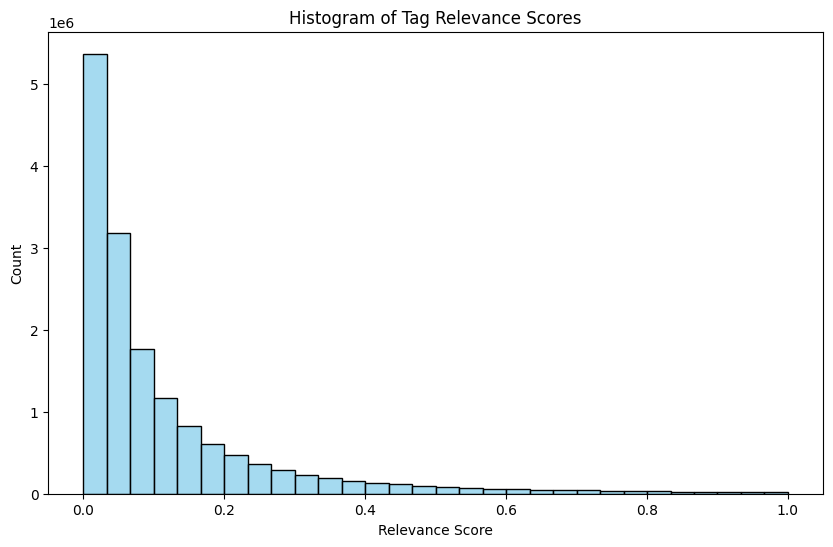

In [15]:
# Visualization 2: Tag Relevance Histogram
def plot_tag_relevance(data):
    plt.figure(figsize=(10, 6))
    sns.histplot(data['relevance'], bins=30, color='skyblue')
    plt.title('Histogram of Tag Relevance Scores')
    plt.xlabel('Relevance Score')
    plt.ylabel('Count')
    plt.savefig('/l/users/chaimaa.abi/BigData2/BigData/assets/Notebook3_tag_relevance_histogram.png') 
    plt.show()

plot_tag_relevance(complete_movie_data)

In [23]:
# For each movie, compute the relevance rank of tags so we can eventually rank order tags for each movie
complete_movie_data['tag_significance_rank'] = complete_movie_data.groupby("movieId")["relevance"].rank(method="first", ascending=False).astype('int64')

# Filter the dataset to consider only tags with tag_significance_rank up to 500
top_ranks_data = complete_movie_data[complete_movie_data['tag_significance_rank'] <= 100]

# Compute median relevance score for each relevance rank
median_scores_by_rank = top_ranks_data.groupby('tag_significance_rank')['relevance'].median().reset_index(name='median_relevance')

# Setting up the plotting style
sns.set(style="whitegrid")

# Create a figure for plotting
plt.figure(figsize=(200, 60))

# Create a box plot showing the distribution of relevance scores for each relevance rank
box_plot = sns.boxplot(
    x='tag_significance_rank', 
    y='relevance', 
    data=top_ranks_data, 
    showfliers=False,  # Optionally hide outliers to focus on the majority of the data
    color='lightblue'
)

# Overlay a line plot showing the trend of the median relevance score by rank
line_plot = sns.lineplot(
    x='tag_significance_rank', 
    y='median_relevance', 
    data=median_scores_by_rank, 
    marker='o', 
    color='red', 
    label='Median Relevance Trend'
)

# Add a vertical line at rank 70 to highlight it
plt.axvline(x=70, color='green', linestyle='--', linewidth=7)

# Optionally, add a horizontal line at the median relevance score of rank 70 if you wish to emphasize it
median_relevance_at_70 = median_scores_by_rank[median_scores_by_rank['tag_significance_rank'] == 70]['median_relevance'].values[0]
plt.axhline(y=median_relevance_at_70, color='purple', linestyle='--', linewidth=2)

# Customize the plot with labels and a title
plt.xlabel('Relevance Rank within Movies', fontsize=14)
plt.ylabel('Relevance Score', fontsize=14)
plt.title('Distribution of Tag Relevance Scores by Rank within Movies', fontsize=18, weight='bold')
plt.legend()
plt.savefig('/l/users/chaimaa.abi/BigData2/BigData/assets/Notebook3_tag_relevance_distribution.png')  # Add this line to save the figure

# Show the plot
plt.show()


In [17]:
# Filter data to include only top 70 tags per movie
top_tags = complete_movie_data[complete_movie_data['tag_significance_rank'] <= 70]

# Pivot table to create a matrix of movies by tags, using maximum relevance score
tag_matrix = top_tags.pivot_table(index='movieId', columns='standardized_tag', values='relevance', aggfunc='max', fill_value=0)

# Convert relevance scores to binary (1 if relevance > 0 else 0)
binary_tag_matrix = tag_matrix.applymap(lambda x: 1 if x > 0 else 0)

# Compute Cosine Similarity
cosine_similarity = 1 - pairwise_distances(tag_matrix, metric='cosine')
cosine_similarity = pd.DataFrame(cosine_similarity, index=tag_matrix.index, columns=tag_matrix.index)

# Compute Jaccard Similarity
try:
    jaccard_similarity = 1 - pairwise_distances(binary_tag_matrix.to_numpy(), metric='jaccard')
    jaccard_similarity = pd.DataFrame(jaccard_similarity, index=tag_matrix.index, columns=tag_matrix.index)
    print("Jaccard similarity calculated successfully.")
except Exception as e:
    print(f"An error occurred: {e}")

# Function to compute Overlap Coefficient
def overlap_coefficient_vectorized(matrix):
    mat = matrix.to_numpy()
    intersection = np.dot(mat, mat.T)
    min_sums = np.minimum(np.sum(mat, axis=1)[:, np.newaxis], np.sum(mat, axis=1))
    overlap = intersection / min_sums
    return pd.DataFrame(overlap, index=matrix.index, columns=matrix.index)

# Apply the function to the binary tag matrix
overlap_similarity = overlap_coefficient_vectorized(binary_tag_matrix)

# Normalize and map movie titles to the indices
complete_movie_data['Title'] = complete_movie_data['Title'].str.lower()
movie_titles = complete_movie_data.drop_duplicates('movieId').set_index('movieId')['Title']
# jaccard_similarity.columns = jaccard_similarity.index.map(movie_titles)
# jaccard_similarity.index = jaccard_similarity.index.map(movie_titles)
# cosine_similarity.columns = cosine_similarity.index.map(movie_titles)
# cosine_similarity.index = cosine_similarity.index.map(movie_titles)
# overlap_similarity.columns = overlap_similarity.index.map(movie_titles)
# overlap_similarity.index = overlap_similarity.index.map(movie_titles)


/home/chaimaa.abi/.conda/envs/jinxedv2/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Jaccard similarity calculated successfully.


In [18]:
# Ensure indices and columns are set correctly
jaccard_similarity.index = jaccard_similarity.columns = movie_titles.index
cosine_similarity.index = cosine_similarity.columns = movie_titles.index
overlap_similarity.index = overlap_similarity.columns = movie_titles.index

In [19]:
filtered_data = complete_movie_data

user_liked_movie_titles = [
    "Toy Story",          # Animation/Family
    "Finding Nemo",       # Animation/Adventure
    "Shrek",              # Animation/Adventure
    "The Lion King",      # Animation/Drama
    "Tarzan"      # Animation/Drama
]

user_liked_movie_titles = [movie.lower() for movie in user_liked_movie_titles]

# Filter the data to include only user-liked movies
user_likes = filtered_data[filtered_data['Title'].isin(user_liked_movie_titles)]['movieId'].unique()

def get_recommendations_with_titles(similarity_matrix, movie_ids, titles, top_n=10):
    # Check if movie_ids are in the index to avoid KeyError
    valid_movie_ids = [mid for mid in movie_ids if mid in similarity_matrix.index]
    if not valid_movie_ids:
        return []
    
    # Extract similarity scores for user-liked movies
    sim_scores = similarity_matrix.loc[valid_movie_ids].mean(axis=0)
    # Sort movies based on similarity score
    recommended_movie_ids = sim_scores.sort_values(ascending=False).index.values
    # Exclude movies the user already likes and select top N recommendations
    recommended_movie_ids = [mid for mid in recommended_movie_ids if mid not in valid_movie_ids][:top_n]
    # Map IDs to titles
    recommended_titles = titles.loc[recommended_movie_ids].values
    return recommended_titles


In [20]:
# Get top 10 recommendations for each similarity measure with titles
top_10_jaccard_titles = get_recommendations_with_titles(jaccard_similarity, user_likes, movie_titles, top_n=10)
top_10_cosine_titles = get_recommendations_with_titles(cosine_similarity, user_likes, movie_titles, top_n=10)
top_10_overlap_titles = get_recommendations_with_titles(overlap_similarity, user_likes, movie_titles, top_n=10)

# Print the recommendations
print("Top 10 Jaccard Recommendations:")
for title in top_10_jaccard_titles:
    print(title)

print("\nTop 10 Cosine Recommendations:")
for title in top_10_cosine_titles:
    print(title)

print("\nTop 10 Overlap Recommendations:")
for title in top_10_overlap_titles:
    print(title)


Top 10 Jaccard Recommendations:
a bugs life
ice age
toy story 2
the jungle book
monsters, inc
the emperors new groove
hercules
bolt
frozen
aladdin

Top 10 Cosine Recommendations:
ice age
a bugs life
toy story 2
hercules
the jungle book
the tigger movie
the emperors new groove
monsters, inc
antz
bolt

Top 10 Overlap Recommendations:
ice age
a bugs life
toy story 2
the jungle book
the emperors new groove
hercules
monsters, inc
bolt
frozen
aladdin


Figure saved to //l/users/chaimaa.abi/BigData2/BigData/assets/Notebook3_recommendations_wordcloud.png


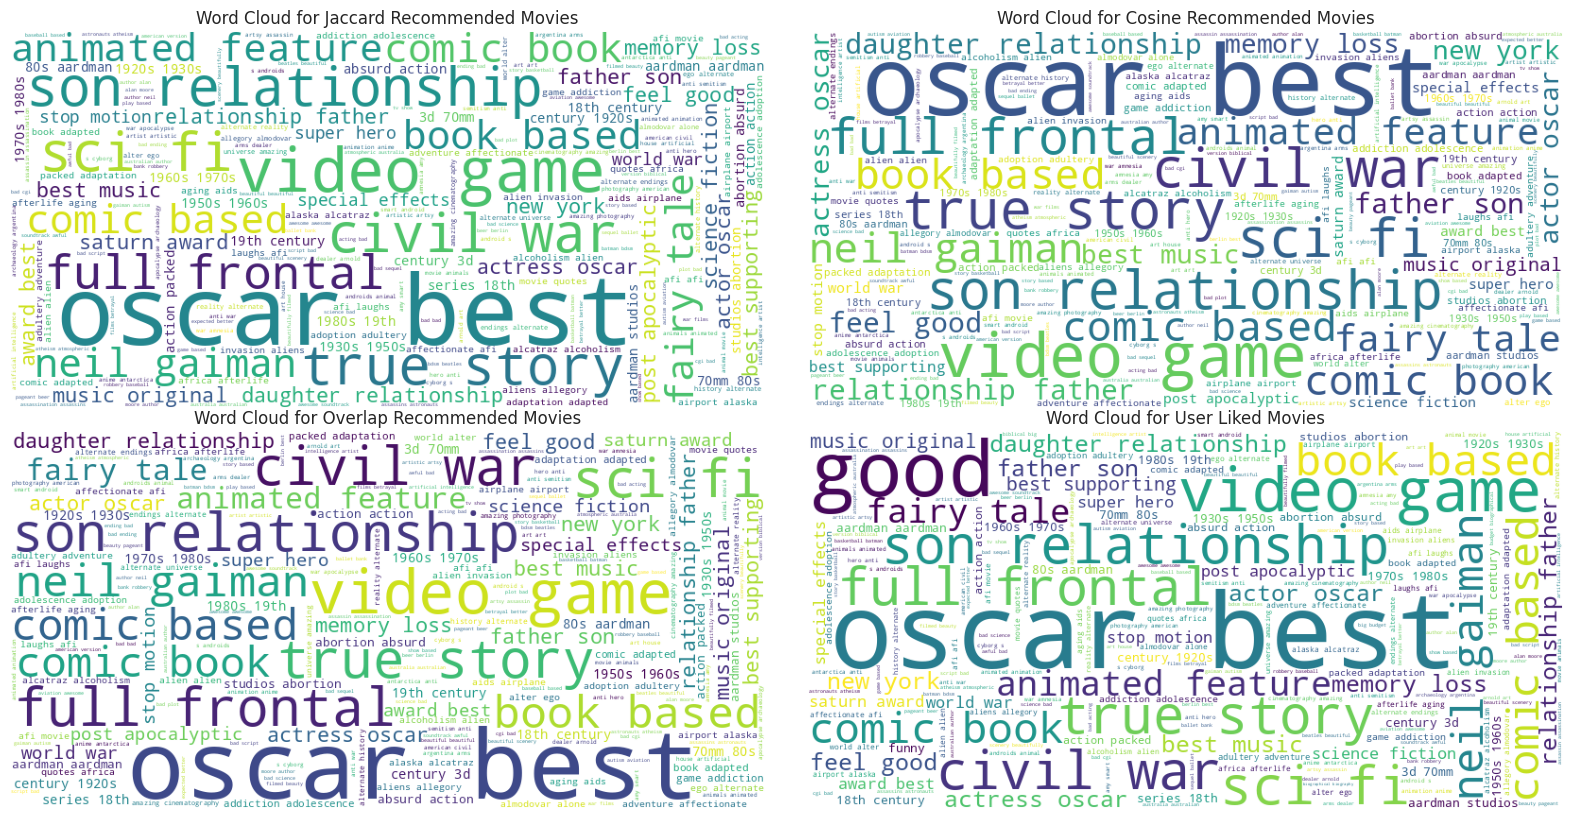

In [24]:
def plot_tag_clouds(movie_title_groups, titles, save_path=None):
    fig, axes = plt.subplots(2, 2, figsize=(16, 8))  # Create a 2x2 grid of subplots
    axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easier iteration

    for ax, movie_titles, title in zip(axes, movie_title_groups, titles):
        # Aggregate tags for specified movies by titles
        tags = " ".join(filtered_data[filtered_data['Title'].str.lower().isin([title.lower() for title in movie_titles])]['tag'])
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(tags)
        ax.imshow(wordcloud)
        ax.axis("off")
        ax.set_title(title)

    plt.tight_layout(pad=0)
    
    if save_path:
        plt.savefig(save_path, format='png', bbox_inches='tight')
        print(f"Figure saved to {save_path}")
    else:
        plt.show()

# Example titles for each subplot
titles = [
    "Word Cloud for Jaccard Recommended Movies",
    "Word Cloud for Cosine Recommended Movies",
    "Word Cloud for Overlap Recommended Movies",
    "Word Cloud for User Liked Movies"
]

# Path where you want to save the figure
save_path = "//l/users/chaimaa.abi/BigData2/BigData/assets/Notebook3_recommendations_wordcloud.png"

# Call the function with groups of movie titles, titles for plots, and a save path
plot_tag_clouds([top_10_jaccard_titles, top_10_cosine_titles, top_10_overlap_titles, user_liked_movie_titles], titles, save_path)